In [3]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import qiskit
from qiskit import transpile, assemble
from qiskit.visualization import *

In [4]:
class QuantumCircuit:
    def __init__(self, n_qubits, backend, shots):
        self._circuit = qiskit.QuantumCircuit(n_qubits)
        
        all_qubits = [i for i in range(n_qubits)]
        self.theta = qiskit.circuit.Parameter('theta')
        
        self._circuit.h(all_qubits)
        self._circuit.barrier()
        self._circuit.rx(self.theta, all_qubits)
        self._circuit.ry(self.theta, all_qubits)
#         self._circuit.rz(self.theta, all_qubits)
        
        self._circuit.measure_all()

        self.backend = backend
        self.shots = shots
    
    def run(self, thetas):
        t_qc = transpile(self._circuit,
                         self.backend)
        qobj = assemble(t_qc,
                        shots=self.shots,
                        parameter_binds = [{self.theta: theta} for theta in thetas])
        job = self.backend.run(qobj)
        result = job.result().get_counts()
        
        counts = np.array(list(result.values()))
        states = np.array(list(result.keys())).astype(float)
        
        probabilities = counts / self.shots
        expectation = np.sum(states * probabilities)
        
        return np.array([expectation])

In [5]:
simulator = qiskit.Aer.get_backend('aer_simulator')

circuit = QuantumCircuit(1, simulator, 100)
circuit._circuit.draw( )

┌───┐ ░ ┌───────────┐┌───────────┐ ░ ┌─┐
     q: ┤ H ├─░─┤ Rx(theta) ├┤ Ry(theta) ├─░─┤M├
        └───┘ ░ └───────────┘└───────────┘ ░ └╥┘
meas: 1/══════════════════════════════════════╩═
                                              0

In [6]:
class HybridFunction(Function):
    def forward(ctx, input, quantum_circuit, shift):
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        expectation_z = ctx.quantum_circuit.run(input[0].tolist())
        result = torch.tensor([expectation_z])
        ctx.save_for_backward(input, result)

        return result
      
    def backward(ctx, grad_output):
        input, expectation_z = ctx.saved_tensors
        input_list = np.array(input.tolist())
        
        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift
        
        gradients = []
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run(shift_right[i])
            expectation_left  = ctx.quantum_circuit.run(shift_left[i])
            
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients.append(gradient)
            
        gradients = np.array([gradients]).T
        return torch.tensor([gradients]).float() * grad_output.float(), None, None

class Hybrid(nn.Module):
    def __init__(self, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = QuantumCircuit(1, backend, shots)
        self.shift = shift
        
    def forward(self, input):
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)

In [7]:
class dataset(Dataset):
  def __init__(self,x,y):
    self.x = torch.tensor(x)
    self.y = torch.tensor(y)
    self.length = self.x.shape[0]
 
  def __getitem__(self,idx):
    return (self.x[idx], self.y[idx])

  def __len__(self):
    return self.length

In [8]:
data = load_breast_cancer()
x = data['data']
y = data['target']

X_train = dataset(x, y)
train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True)

sc = StandardScaler()
x = sc.fit_transform(x)

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(30, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 1)
        self.hybrid = Hybrid(qiskit.Aer.get_backend("aer_simulator"), 100, np.pi / 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        x = self.hybrid(x)
        return torch.cat((x, 1 - x), -1)

# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(30, 64)
#         self.fc2 = nn.Linear(64, 128)
#         self.fc3 = nn.Linear(128, 1)
# #         self.hybrid = Hybrid(qiskit.Aer.get_backend("aer_simulator"), 100, np.pi / 2)

#     def forward(self, x):
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = F.sigmoid(self.fc3(x))

# #         x = self.fc3(x)
# #         x = self.hybrid(x)
#         return x
# #         return torch.cat((x, 1 - x), -1)

In [12]:
%%time
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 50
loss_list = []

model.train()

for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        inp = torch.tensor(data, dtype=torch.float32)
        output = model(inp)
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()
        
        total_loss.append(loss.item())
        
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))

<timed exec>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
<ipython-input-6-1d7e14d9bab1>:27: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  gradients = np.array([gradients]).T


Training [2%]	Loss: -0.5253
Training [4%]	Loss: -0.5355
Training [6%]	Loss: -0.5717
Training [8%]	Loss: -0.6035
Training [10%]	Loss: -0.7552
Training [12%]	Loss: -0.8019
Training [14%]	Loss: -0.8049
Training [16%]	Loss: -0.8029
Training [18%]	Loss: -0.8124
Training [20%]	Loss: -0.8066
Training [22%]	Loss: -0.7982
Training [24%]	Loss: -0.8147
Training [26%]	Loss: -0.8225
Training [28%]	Loss: -0.8032
Training [30%]	Loss: -0.8161
Training [32%]	Loss: -0.8185
Training [34%]	Loss: -0.8320
Training [36%]	Loss: -0.8355
Training [38%]	Loss: -0.8540
Training [40%]	Loss: -0.8718
Training [42%]	Loss: -0.8686
Training [44%]	Loss: -0.8773
Training [46%]	Loss: -0.8762
Training [48%]	Loss: -0.8689
Training [50%]	Loss: -0.8712
Training [52%]	Loss: -0.8790
Training [54%]	Loss: -0.8807
Training [56%]	Loss: -0.8825
Training [58%]	Loss: -0.8850
Training [60%]	Loss: -0.8864
Training [62%]	Loss: -0.8956
Training [64%]	Loss: -0.9026
Training [66%]	Loss: -0.8833
Training [68%]	Loss: -0.8892
Training [70%]	Los

Text(0, 0.5, 'Neg Log Likelihood Loss')

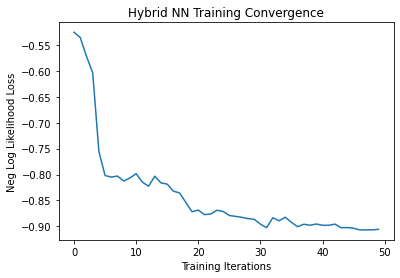

In [14]:
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')